In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Basic Simulation
---

In [2]:
import functools
import itertools

import simpy
import numpy as np
import pandas as pd

In [3]:
def interarrival():
    return np.random.exponential()


def service():
    return np.random.exponential()

In [4]:
def source(env, partition):
    cntr = itertools.count(start=0)
    while True:
        yield env.timeout(interarrival())
        # A job has arrived.
        env.process(job(env, partition, next(cntr)))


def job(env, partition, idx):
    with partition.request() as req:
        # Wait for a machine to free up.
        yield req
        # Run my job.
        yield env.timeout(service())

In [5]:
def patch_resource(resource, pre=None, post=None):
    """Patch *resource* so that it calls the callable *pre* before each
    put/get/request/release operation and the callable *post* after each
    operation.  The only argument to these functions is the resource
    instance.

    """
    def get_wrapper(func):
        # Generate a wrapper for put/get/request/release
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            # This is the actual wrapper
            # Call "pre" callback
            if pre:
                pre(resource)

            # Perform actual operation
            ret = func(*args, **kwargs)

            # Call "post" callback
            if post:
                post(resource)

            return ret
        return wrapper

    # Replace the original operations with our wrapper
    for name in ['put', 'get', 'request', 'release']:
        if hasattr(resource, name):
            setattr(resource, name, get_wrapper(getattr(resource, name)))
    return resource


def monitor(data, resource):
    """This is our monitoring callback."""
    data.append({
        "clock": resource._env.now,
        "usage": resource.count,
        "queue": len(resource.queue),
        "total": resource.count + len(resource.queue)
    })

In [6]:
data = []
env = simpy.Environment()
partition = patch_resource(
    simpy.Resource(env, capacity=2),
    pre=functools.partial(monitor, data)
)
env.process(source(env, partition))
env.run(until=100)

In [7]:
data = pd.DataFrame(data).set_index("clock")

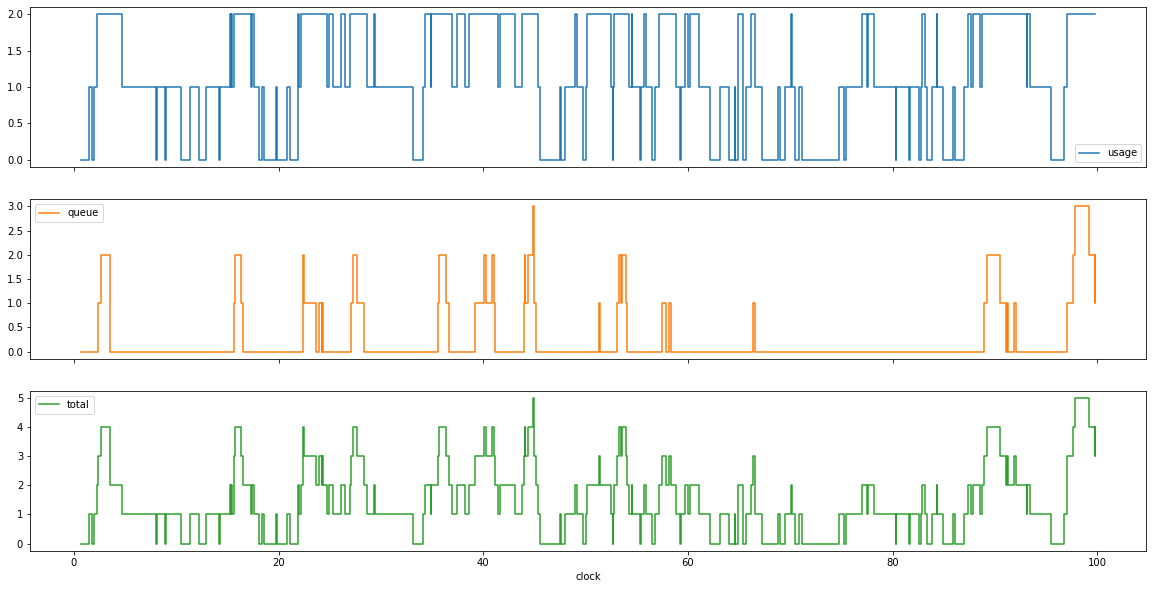

In [8]:
axes = data.plot(figsize=(20, 10), drawstyle="steps-post", subplots=True)

### Scratch
---

In [9]:
import scipy.stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF

In [70]:
data = pd.read_csv("../data/squeued.20211111.cleaned.csv")
# Convert SERVICE_TIME to hours.
data["SERVICE_TIME"] = pd.to_timedelta(data["SERVICE_TIME"]) / np.timedelta64(1, "h")

<AxesSubplot:>

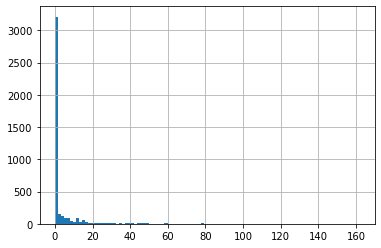

In [12]:
data.SERVICE_TIME.hist(bins=100)

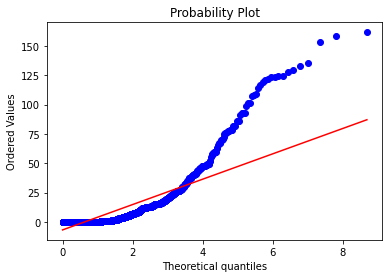

In [13]:
rslt = scipy.stats.probplot(data.SERVICE_TIME, dist="expon", plot=pylab)

In [14]:
ecdf = ECDF(data.SERVICE_TIME)

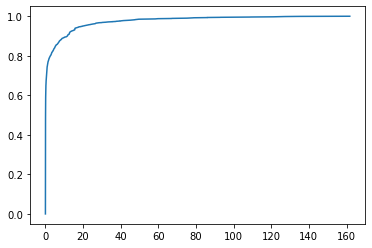

In [15]:
plt.plot(ecdf.x, ecdf.y)

In [16]:
def sample_ecdf():
    while True:
        u = np.random.uniform(0, max(ecdf.x))
        threshold = ecdf(u)
        if np.random.uniform(0, 1) > threshold:
            return u

In [17]:
samples = pd.DataFrame([sample_ecdf() for _ in range(1000)])

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

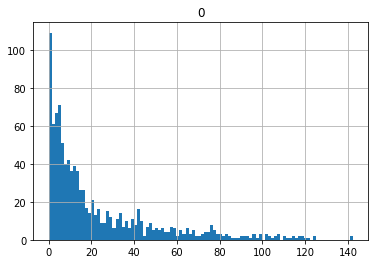

In [18]:
samples.hist(bins=100)

In [19]:
kde = scipy.stats.gaussian_kde(data.SERVICE_TIME)

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

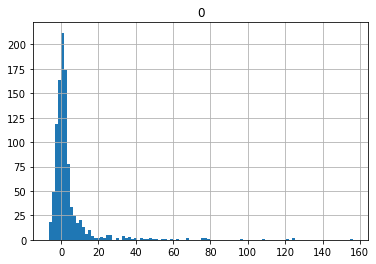

In [20]:
pd.DataFrame(kde.resample(1000).T).hist(bins=100)

In [21]:
# https://stackoverflow.com/questions/64272855/smooth-approximation-of-kde-in-python

In [22]:
kde = sm.nonparametric.KDEUnivariate(data.SERVICE_TIME)

In [23]:
kde.fit()

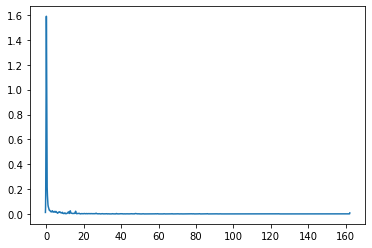

In [24]:
plt.plot(kde.support,kde.density)

In [25]:
f = scipy.interpolate.interp1d(np.linspace(0, 1, num=kde.icdf.size), kde.icdf)

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

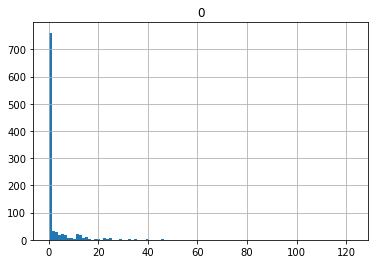

In [26]:
pd.DataFrame([f(np.random.uniform(0, 1)) for _ in range(1000)]).hist(bins=100)

In [27]:
def sampler(data):
    kde = sm.nonparametric.KDEUnivariate(data)
    kde.fit()
    icdf = scipy.interpolate.interp1d(np.linspace(0, 1, num=kde.icdf.size), kde.icdf)
    while True:
        yield icdf(np.random.uniform(0, 1))

In [28]:
smplr = sampler(data.SERVICE_TIME)

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

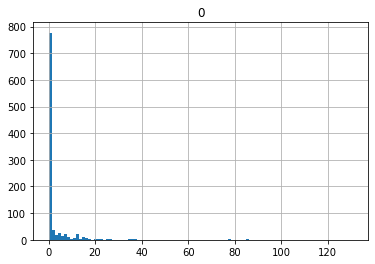

In [29]:
pd.DataFrame([next(smplr) for _ in range(1000)]).hist(bins=100)

### Input Analysis
---

In [30]:
import scipy.stats
import statsmodels.api as sm

In [31]:
def sampler(data):
    kde = sm.nonparametric.KDEUnivariate(data)
    kde.fit()
    icdf = scipy.interpolate.interp1d(np.linspace(0, 1, num=kde.icdf.size), kde.icdf)
    return lambda: icdf(np.random.uniform(0, 1))

In [71]:
data = pd.read_csv("../data/squeued.20211111.cleaned.csv")
data = data[data.PARTITION == "extended-24core"]
# Compute service times in hours.
service_times = (pd.to_timedelta(data["SERVICE_TIME"]) / np.timedelta64(1, "h")).values
# Compute interarrival times in hours.
interarrival_times = (pd.to_datetime(data["SUBMIT_TIME"]).sort_values().diff().dropna() / np.timedelta64(1, "h")).values

In [34]:
service = sampler(service_times)
interarrival = sampler(interarrival_times)

<AxesSubplot:title={'center':'Interarrival Times'}>

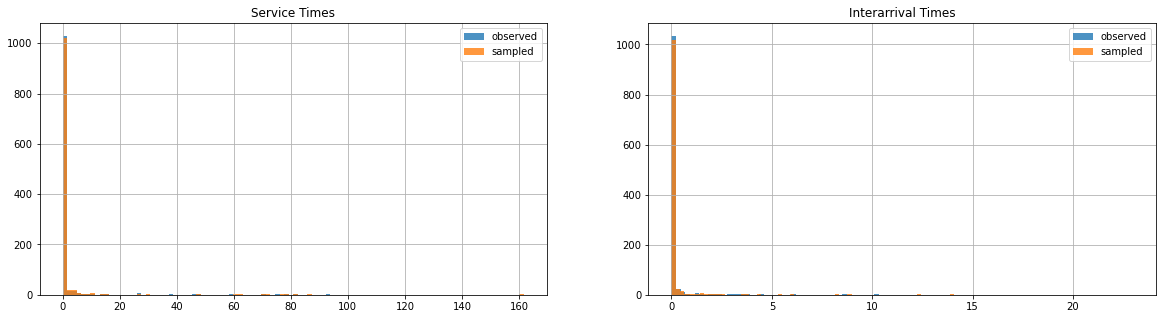

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
axes[0].set_title("Service Times")
df = pd.DataFrame({"observed": service_times, "sampled": [service() for st in service_times]})
df.observed.hist(ax=axes[0], bins=100, legend=True, alpha=0.8)
df.sampled.hist(ax=axes[0], bins=100, legend=True, alpha=0.8)

axes[1].set_title("Interarrival Times")
df = pd.DataFrame({"observed": interarrival_times, "sampled": [interarrival() for it in interarrival_times]})
df.observed.hist(ax=axes[1], bins=100, legend=True, alpha=0.8)
df.sampled.hist(ax=axes[1], bins=100, legend=True, alpha=0.8,)

In [36]:
capacity = len(data.EXEC_HOST.unique())
capacity

70

### Advanced Simulation
---

In [37]:
data = []
env = simpy.Environment()
partition = patch_resource(
    simpy.Resource(env, capacity=round(capacity * 0.2)),
    pre=functools.partial(monitor, data)
)
env.process(source(env, partition))
env.run(until=24 * 30)

In [38]:
data = pd.DataFrame(data).set_index("clock")

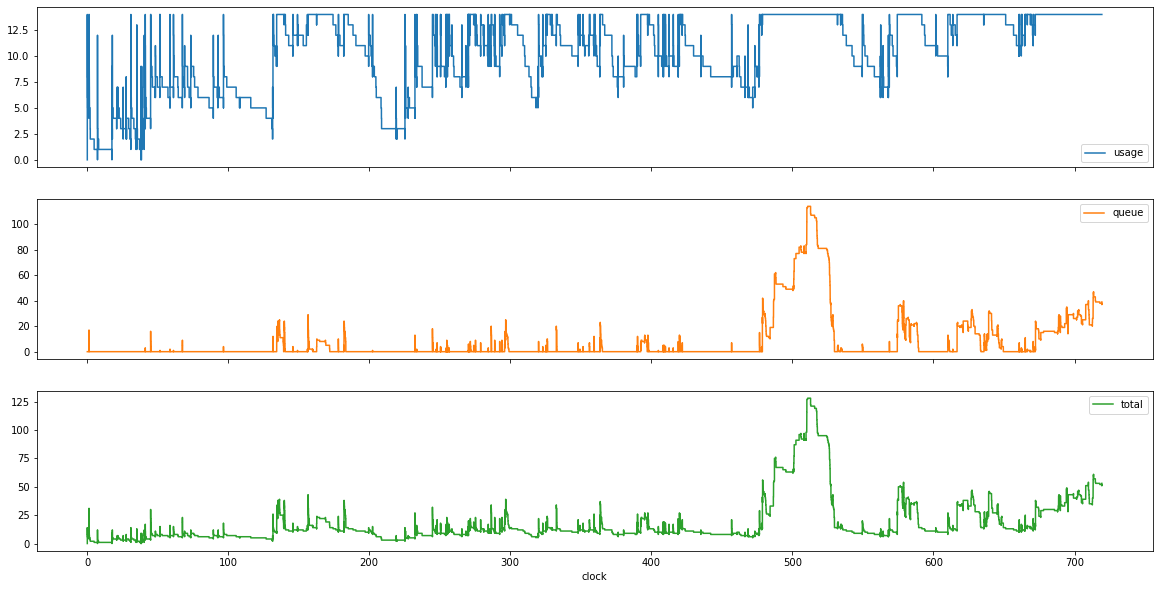

In [39]:
axes = data.plot(figsize=(20, 10), drawstyle="steps-post", subplots=True)

### Empirical Simulation
---

In [77]:
data = pd.read_csv("../data/squeued.20211111.cleaned.csv")
data = data[data.PARTITION == "extended-24core"].sort_values(by="SUBMIT_TIME")
# Compute service times in hours.
service_times = (pd.to_timedelta(data["SERVICE_TIME"]) / np.timedelta64(1, "h")).values
# Compute interarrival times in hours.
interarrival_times = (pd.to_datetime(data["SUBMIT_TIME"]).sort_values().diff().dropna() / np.timedelta64(1, "h")).values

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

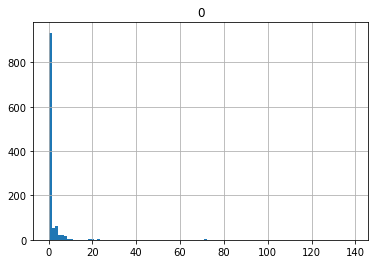

In [73]:
pd.DataFrame((pd.to_datetime(data.START_TIME) - pd.to_datetime(data.SUBMIT_TIME)) / np.timedelta64(1, "h")).hist(bins=100)

In [74]:
capacity = len(data.EXEC_HOST.unique())
capacity

70

In [75]:
def service():
    vals = list(service_times)
    def fn():
        while vals:
            return vals.pop(0)
    return fn
service = service()

        
def interarrival():
    vals = list(interarrival_times)
    def fn():
        while vals:
            return vals.pop(0)
        return np.inf
    return fn
interarrival = interarrival()

In [76]:
data = []
env = simpy.Environment()
partition = patch_resource(
    simpy.Resource(env, capacity=capacity),
    pre=functools.partial(monitor, data)
)
env.process(source(env, partition))
env.run(until=1000)

In [46]:
data = pd.DataFrame(data).set_index("clock")

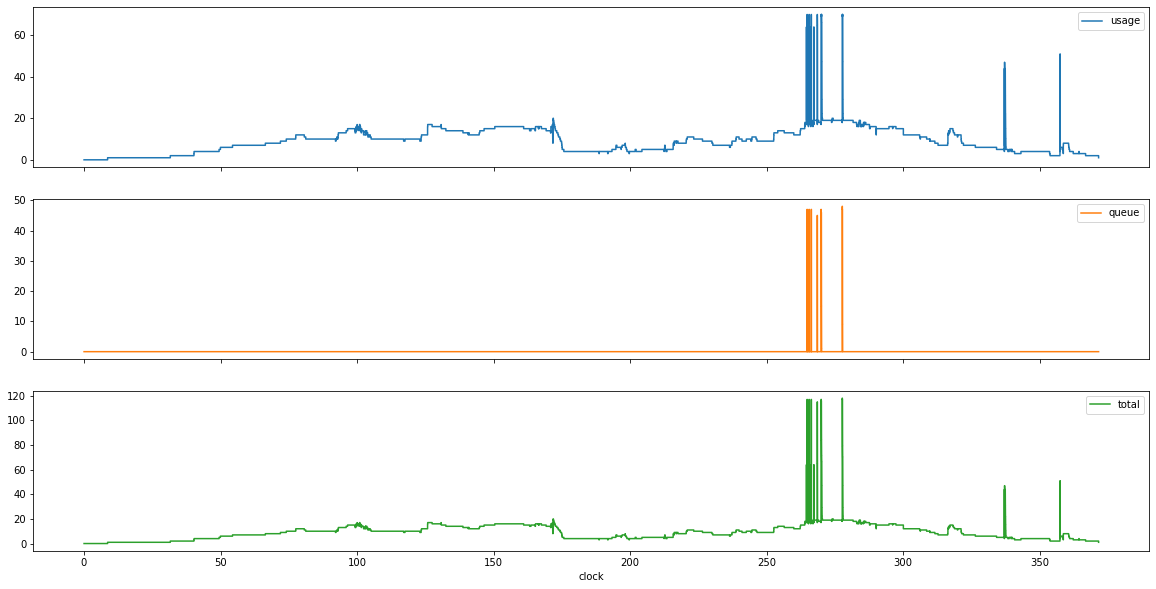

In [47]:
axes = data.plot(figsize=(20, 10), drawstyle="steps-post", subplots=True)

In [51]:
# pd.DataFrame((pd.to_datetime(data.START_TIME) - pd.to_datetime(data.SUBMIT_TIME)) / np.timedelta64(1, "h")).hist(bins=100)

In [78]:
data["DELAY_TIME"] = pd.to_datetime(data.START_TIME) - pd.to_datetime(data.SUBMIT_TIME)

In [80]:
pd.read_csv("../data/squeued.20211111.cleaned.csv").PARTITION.unique()

array(['v100', 'extended-28core', 'long-24core', 'gpu', 'long-28core',
       'debug-28core', 'p100', 'short-40core', 'extended-40core',
       'extended-24core', 'medium-28core', 'long-40core', 'gpu-long',
       'medium-24core', 'short-28core', 'short-24core', 'gpu-large',
       'large-28core', 'medium-40core', 'large-40core'], dtype=object)

In [81]:
data.NODELIST.unique()

array(['cn013', 'cn036', 'cn057', 'cn015', 'cn093', 'cn087', 'cn047',
       'cn051', 'cn084', 'cn016', 'cn076', 'cn094', 'cn009', 'cn002',
       'cn012', 'cn072', 'cn039', 'cn035', 'cn001', 'cn031', 'cn046',
       'cn056', 'cn005', 'cn008', 'cn027', 'cn010', 'cn098', 'cn099',
       'cn004', 'cn011', 'cn040', 'cn025', 'cn003', 'cn100', 'cn032',
       'cn055', 'cn037', 'cn060', 'cn038', 'cn058', 'cn028', 'cn045',
       'cn029', 'cn[052-053]', 'cn077', 'cn078', 'cn[063-064]',
       'cn[065-066]', 'cn[049-050]', 'cn[078-079]', 'cn[051-052]',
       'cn061', 'cn[053-054]', 'cn080', 'cn068', 'cn074', 'cn075',
       'cn[011-012]', 'cn[067,100]', 'cn026', 'cn014', 'cn052', 'cn067',
       'cn088', 'cn086', 'cn034', 'cn006', 'cn073', 'cn030', 'cn017',
       'cn069', 'cn070', 'cn081', 'cn082', 'cn007'], dtype=object)

In [82]:
data.columns.unique()

Index(['Unnamed: 0', 'ACCOUNT', 'GRES', 'MIN_CPUS', 'MIN_TMP_DISK', 'END_TIME',
       'FEATURES', 'GROUP', 'OVER_SUBSCRIBE', 'JOBID', 'NAME', 'COMMENT',
       'TIME_LIMIT', 'MIN_MEMORY', 'REQ_NODES', 'COMMAND', 'PRIORITY', 'QOS',
       'REASON', 'ST', 'USER', 'RESERVATION', 'WCKEY', 'EXC_NODES', 'NICE',
       'S:C:T', 'JOBID.1', 'EXEC_HOST', 'CPUS', 'NODES', 'DEPENDENCY',
       'ARRAY_JOB_ID', 'GROUP.1', 'SOCKETS_PER_NODE', 'CORES_PER_SOCKET',
       'THREADS_PER_CORE', 'ARRAY_TASK_ID', 'TIME_LEFT', 'TIME', 'NODELIST',
       'CONTIGUOUS', 'PARTITION', 'PRIORITY.1', 'NODELIST(REASON)',
       'START_TIME', 'STATE', 'USER.1', 'SUBMIT_TIME', 'LICENSES', 'CORE_SPEC',
       'SCHEDNODES', 'WORK_DIR', 'LAST_SEEN', 'COMPLETE', 'SERVICE_TIME',
       'DELAY_TIME'],
      dtype='object')

In [83]:
data.CPUS.unique()

array([24, 48], dtype=int64)

### Fitting Nodes Data
---

In [84]:
import shelve

In [85]:
with shelve.open("../data/squeued.20211125.shelf") as db:
    df = pd.DataFrame(db.values())
df

,ACCOUNT,GRES,MIN_CPUS,MIN_TMP_DISK,END_TIME,FEATURES,GROUP,OVER_SUBSCRIBE,JOBID,NAME,...,START_TIME,STATE,USER.1,SUBMIT_TIME,LICENSES,CORE_SPEC,SCHEDNODES,WORK_DIR,LAST_SEEN,COMPLETE
0,pn_chlu012318s,(null),2,0,NaN,(null),mengxwang,NO,677353,pymc3seg,...,NaN,PENDING,112673860,2021-11-19T16:16:12,(null),NaN,(null),/gpfs/home/mengxwang/HRS,2021-11-26T15:54:35.317765,False
1,pn_navi08092019s,(null),1,0,NaN,(null),nvitek,NO,679413_[90-99],mapHigh,...,NaN,PENDING,170128546,2021-11-23T12:08:31,(null),NaN,(null),/gpfs/scratch/nvitek/PuenteAlignment-Slurm/code,2021-11-25T18:31:52.084016,True
2,pn_yude051117s,(null),40,0,NaN,(null),odiamond,NO,577519,m5,...,NaN,PENDING,170228031,2021-07-28T20:36:30,(null),NaN,(null),/gpfs/scratch/odiamond,2021-11-26T15:54:35.317765,False
3,pn_yude051117s,(null),40,0,NaN,(null),pguo,NO,670998,tensorflow-hr,...,NaN,PENDING,111679733,2021-11-06T22:27:23,(null),NaN,(null),/gpfs/home/pguo/mydoc,2021-11-26T15:54:35.317765,False
4,pn_yude051117s,(null),40,0,NaN,(null),pguo,NO,670999,tensorflow-hr,...,NaN,PENDING,111679733,2021-11-06T22:27:24,(null),NaN,(null),/gpfs/home/pguo/mydoc,2021-11-26T15:54:35.317765,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,pn_navi08092019s,(null),1,0,NaN,(null),nvitek,NO,680670_[12-99],mapHigh,...,NaN,PENDING,170128546,2021-11-26T11:07:25,(null),NaN,(null),/gpfs/scratch/nvitek/PuenteAlignment-Slurm/code,2021-11-26T15:54:35.317765,False
417,pn_papo092120s,(null),24,0,2021-11-26T16:00:30,(null),nichaturvedi,NO,680758,bash,...,2021-11-26T15:40:30,RUNNING,112847605,2021-11-26T15:40:30,(null),NaN,(null),/gpfs/home/nichaturvedi,2021-11-26T15:54:35.317765,False
418,pn_kela10222021s,(null),28,0,2021-11-26T21:53:14,(null),klanzetta,NO,680759,run_short-28core,...,2021-11-26T17:53:14,PENDING,100235038,2021-11-26T15:42:47,(null),NaN,sn006,/gpfs/home/klanzetta/MaxiMask,2021-11-26T15:54:35.317765,False
419,pn_sace021518s,(null),40,0,NaN,(null),scentorrino,NO,680760,dyntreat21_3,...,NaN,PENDING,110104144,2021-11-26T15:50:38,(null),NaN,(null),/gpfs/scratch/scentorrino/dyn_treat,2021-11-26T15:54:35.317765,False


<AxesSubplot:xlabel='Nodes'>

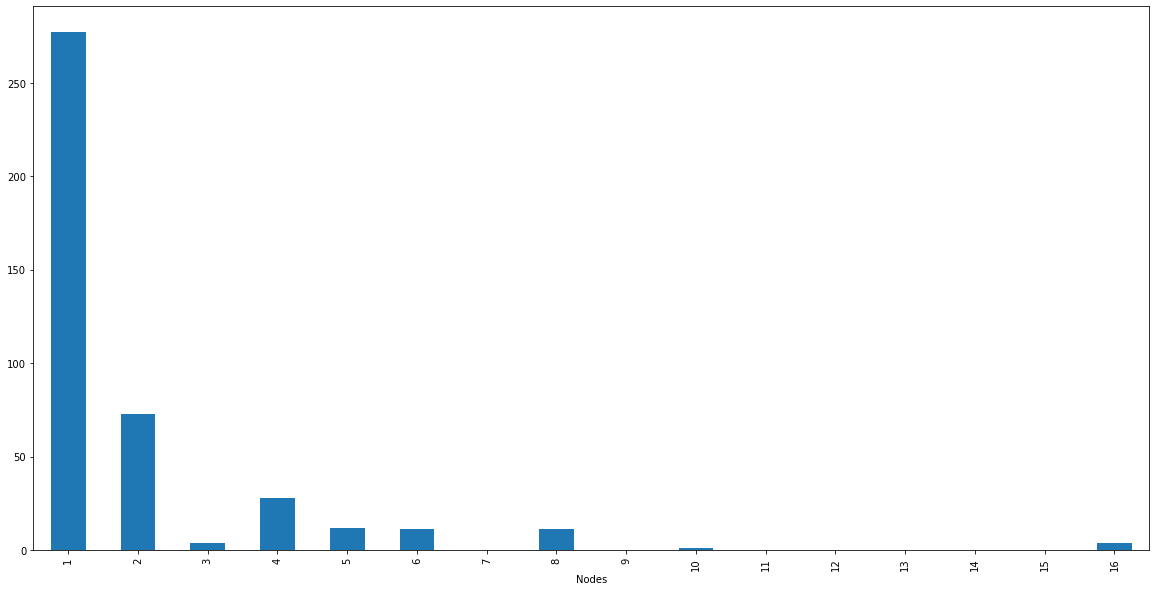

In [86]:
pd.DataFrame([(idx, df.NODES.value_counts().get(idx, 0)) for idx in range(1, 17)], columns=["Nodes", "Count"]).set_index("Nodes").plot(kind="bar", legend=False, figsize=(20, 10))

<AxesSubplot:xlabel='Nodes'>

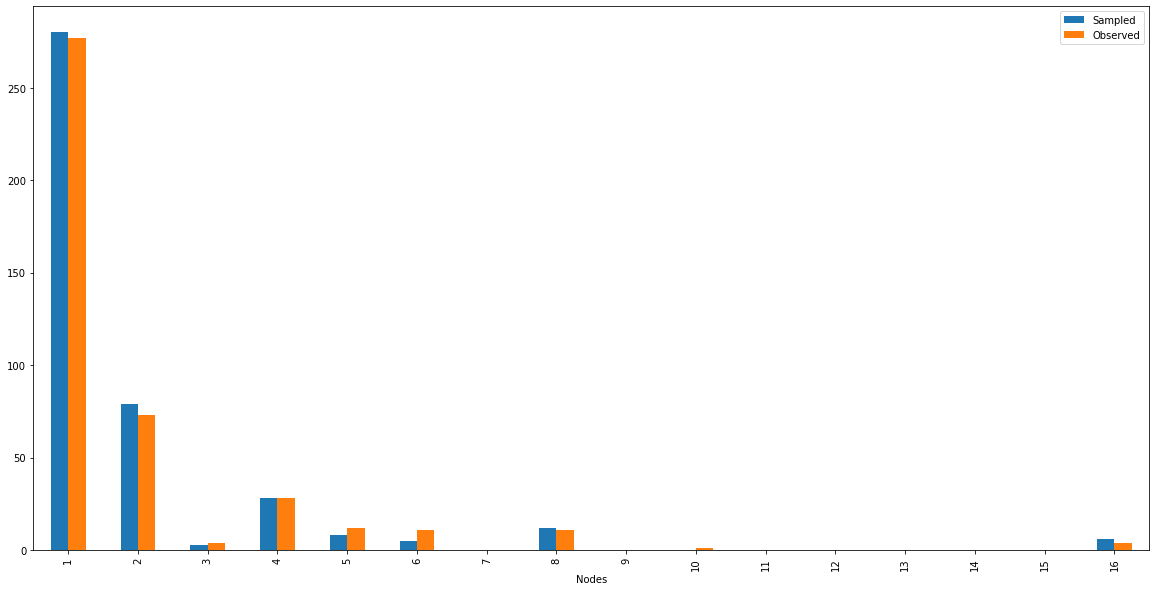

In [87]:
smplr = sampler(df.NODES)
nodes = lambda: int(smplr())
sampled = pd.DataFrame([nodes() for i in df.NODES]).value_counts()
ddf = pd.concat([
    pd.DataFrame([(idx, sampled.get(idx, 0)) for idx in range(1, 17)], columns=["Nodes", "Sampled"]).set_index("Nodes"),
    pd.DataFrame([(idx, df.NODES.value_counts().get(idx, 0)) for idx in range(1, 17)], columns=["Nodes", "Observed"]).set_index("Nodes")
], axis=1)
ddf.plot(kind="bar", figsize=(20, 10))

### Simulation with Nodes
---

In [97]:
sdata = pd.read_csv("../data/squeued.20211111.cleaned.csv")
sdata = sdata[sdata.PARTITION == "extended-24core"].sort_values(by="SUBMIT_TIME")
# Compute service times in hours.
service_times = (pd.to_timedelta(sdata["SERVICE_TIME"]) / np.timedelta64(1, "h")).values
# Compute interarrival times in hours.
interarrival_times = (pd.to_datetime(sdata["SUBMIT_TIME"]).sort_values().diff().dropna() / np.timedelta64(1, "h")).values

In [90]:
service = sampler(service_times)
interarrival = sampler(interarrival_times)

In [99]:
with shelve.open("../data/squeued.20211125.shelf") as db:
    df = pd.DataFrame(db.values())
smplr = sampler(df.NODES)
nodes = lambda: int(smplr())

In [92]:
capacity = len(sdata.EXEC_HOST.unique())
capacity

70

In [93]:
def source(env, partition):
    cntr = itertools.count(start=0)
    while True:
        yield env.timeout(interarrival())
        # A job has arrived.
        env.process(job(env, partition, next(cntr)))
        #for _ in range(nodes()):
        #    env.process(job(env, partition, next(cntr)))


def job(env, partition, idx):
    with partition.request() as req:
        # Wait for a machine to free up.
        yield req
        # Run my job.
        yield env.timeout(service())

In [94]:
data = []
env = simpy.Environment()
partition = patch_resource(
    simpy.Resource(env, capacity=round(capacity)),
    pre=functools.partial(monitor, data)
)
env.process(source(env, partition))
env.run(until=24 * 30)

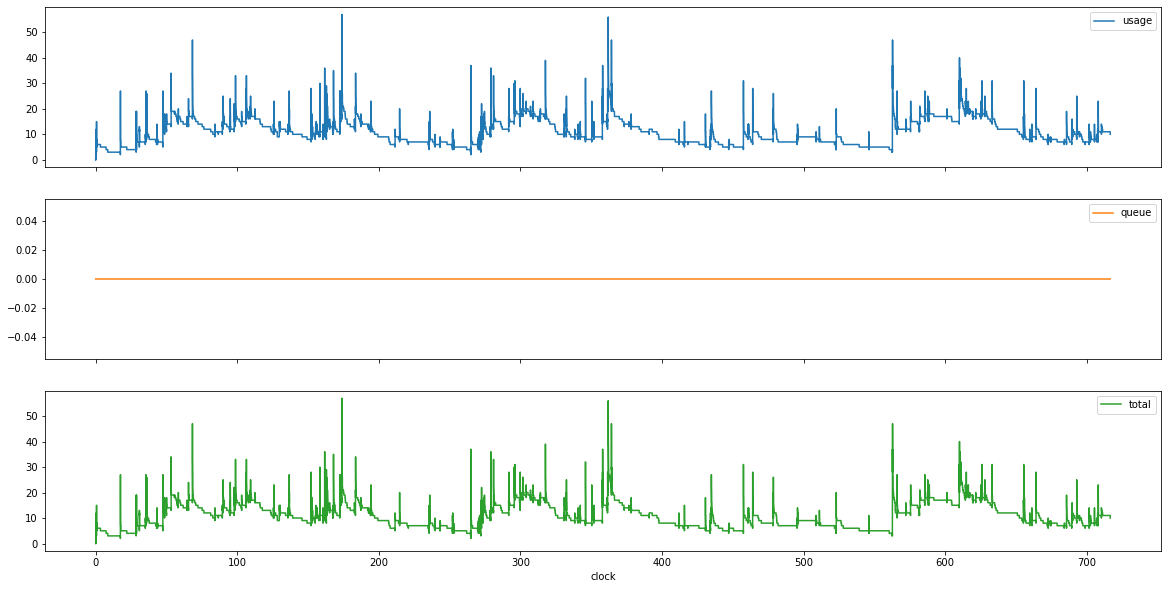

In [95]:
data = pd.DataFrame(data).set_index("clock")
axes = data.plot(figsize=(20, 10), drawstyle="steps-post", subplots=True)

In [177]:
#with shelve.open("../data/squeued.20211125.shelf") as db:
#    df = pd.DataFrame(db.values())
df = pd.read_csv("../data/squeued.20211111.csv")
df = df[df.STATE == "COMPLETING"]
merged_partition_names = []
for p in df.PARTITION:
    merged_partition_names.append(p)
for i in range(len(merged_partition_names)):
    if "24core" in merged_partition_names[i]:
        merged_partition_names[i] = "24core"
    elif "28core" in merged_partition_names[i]:
        merged_partition_names[i] = "28core"
    elif "40core" in merged_partition_names[i]:
        merged_partition_names[i] = "40core"
    elif "gpu" in merged_partition_names[i]:
        merged_partition_names[i] = "gpu"
df.insert(1, "MERGED_PARTITION", merged_partition_names)
df.insert(1, "DELAY_TIME", pd.to_datetime(df.START_TIME) - pd.to_datetime(df.SUBMIT_TIME))
df.insert(1, "SERVICE_TIME", pd.to_datetime(df.END_TIME) - pd.to_datetime(df.START_TIME))

df.to_csv("../data/squeued.20211111.mergedparts3.csv")


In [182]:
df = pd.read_csv("../data/squeued.20211111.mergedparts3.csv").sort_values(by="SUBMIT_TIME")
with shelve.open("../data/squeued.20211125.shelf") as db:
        df2 = pd.DataFrame(db.values())
num_nodes_list = df2.NODES

for partition in ["24core", "28core", "40core", "gpu"]:
    sdata = df[df.MERGED_PARTITION == partition]
    inter_list = (pd.to_datetime(sdata["SUBMIT_TIME"]).sort_values().diff().dropna() / np.timedelta64(1, "h")).values
    #delay = delay_sampler(partition)
    serv_list = (pd.to_timedelta(sdata["SERVICE_TIME"].dropna()) / np.timedelta64(1, "h")).values
    cap = len(sdata.EXEC_HOST.unique())

    print(f"Partition: {partition}")
    print(f"Capacity: {cap}")
    print(f"mean/min/max interarrival time: {np.mean(inter_list):0.5} | {np.min(inter_list):0.5} | {np.max(inter_list):0.5}")
    print(f"mean/min/max service time: {np.mean(serv_list):0.5} | {np.min(serv_list):0.5} | {np.max(serv_list):0.5}")
    print(f"mean/min/max number of requested nodes: {np.mean(num_nodes_list):0.5} | {np.min(num_nodes_list)} | {np.max(num_nodes_list)}")
    print(f"Traffic Intensity: {(np.mean(num_nodes_list)*np.mean(serv_list))/(np.mean(inter_list))}\n")

Partition: 24core
Capacity: 99
mean/min/max interarrival time: 0.19974 | 0.0 | 20.916
mean/min/max service time: 4.6066 | 0.0 | 168.01
mean/min/max number of requested nodes: 1.9834 | 1 | 16
Traffic Intensity: 45.742072102066956

Partition: 28core
Capacity: 146
mean/min/max interarrival time: 0.26512 | 0.0 | 28.044
mean/min/max service time: 8.7831 | 0.0 | 168.01
mean/min/max number of requested nodes: 1.9834 | 1 | 16
Traffic Intensity: 65.7056300843766

Partition: 40core
Capacity: 64
mean/min/max interarrival time: 1.0403 | 0.0 | 288.41
mean/min/max service time: 12.988 | 0.0 | 168.01
mean/min/max number of requested nodes: 1.9834 | 1 | 16
Traffic Intensity: 24.76161257648534

Partition: gpu
Capacity: 9
mean/min/max interarrival time: 0.64185 | 0.00027778 | 19.021
mean/min/max service time: 2.5811 | 0.0 | 48.006
mean/min/max number of requested nodes: 1.9834 | 1 | 16
Traffic Intensity: 7.975904286649329



In [141]:
sdata = pd.read_csv("../data/squeued.20211111.mergedparts.csv")
sdata = sdata[sdata.MERGED_PARTITION == "40core"].sort_values(by="SUBMIT_TIME")
len(sdata.EXEC_HOST.unique())
sdata.DELAY_TIME

36      0 days 00:00:00
12      0 days 06:31:16
24      0 days 00:36:04
39      0 days 00:00:00
40      0 days 00:00:00
             ...       
4104    0 days 00:00:01
4103    0 days 00:00:00
4127    0 days 00:00:27
4136    0 days 00:00:15
4138    0 days 00:32:06
Name: DELAY_TIME, Length: 567, dtype: object